In [1]:
import pickle
from pathlib import Path

import joblib
import keras
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from collections import Counter

from utils import *

In [2]:
pc = ProjectConfig()
MODEL_DIR = pc.project_root_dir.joinpath("src").joinpath("model_fine_tuned_saves")
MODEL_NAME = "efficientnet_v2m"
MODEL_PATH = MODEL_DIR.joinpath(MODEL_NAME + ".h5")
CLASS_LIST_PATH = pc.project_root_dir.joinpath("src").joinpath("class_list.lzma")
TEST_DATA = pc.data_root_dir.joinpath("sampled_test_data_200")

No configuration file found. Using defaults.


In [3]:
if CLASS_LIST_PATH.exists():
    classes = joblib.load(CLASS_LIST_PATH)
else:
    print("No class list found, please run the training script first")

In [4]:
if TEST_DATA.exists() and TEST_DATA.is_dir():
    print("Test data found, loading")
    test_data = tf.keras.utils.image_dataset_from_directory(
        TEST_DATA,
        labels="inferred",
        label_mode="int",
        batch_size=32,
        image_size=(224, 224),
        shuffle=False,
    )
else:
    print("No test data found, where did it go?")

Test data found, loading
Found 5698 files belonging to 69 classes.


In [5]:
if MODEL_PATH.exists():
    model = tf.keras.models.load_model(MODEL_PATH)
    model.trainable = False
    print("Model loaded from disk")
else:
    print("Model not found at path:", MODEL_PATH)



Model loaded from disk


In [6]:
PREDICTIONS_FILE = pc.project_root_dir.joinpath("src").joinpath("predictions.lzma")
if PREDICTIONS_FILE.exists():
    predictions = joblib.load(PREDICTIONS_FILE)
else:
    predictions = model.predict(test_data)
    joblib.dump(predictions, PREDICTIONS_FILE)

In [7]:
predicted_classes = np.argmax(predictions, axis=-1)

In [8]:
true_labels = []
for images, true_label in test_data:
    true_labels.extend(true_label)

In [9]:
all_predictions = np.array(predicted_classes)
all_true_labels = np.array(true_labels)
all_classes = np.array(classes)

In [11]:
precision_score(all_true_labels, all_predictions, average="weighted")

0.9598892969513899

In [12]:
recall_score(all_true_labels, all_predictions, average="weighted")

0.9575289575289575

In [10]:
accuracy_score(all_true_labels, all_predictions)

0.9575289575289575

In [13]:
f1_score(all_true_labels, all_predictions, average="weighted")

0.9581015882493844

In [9]:

conf_matrix = confusion_matrix(all_true_labels, all_predictions)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

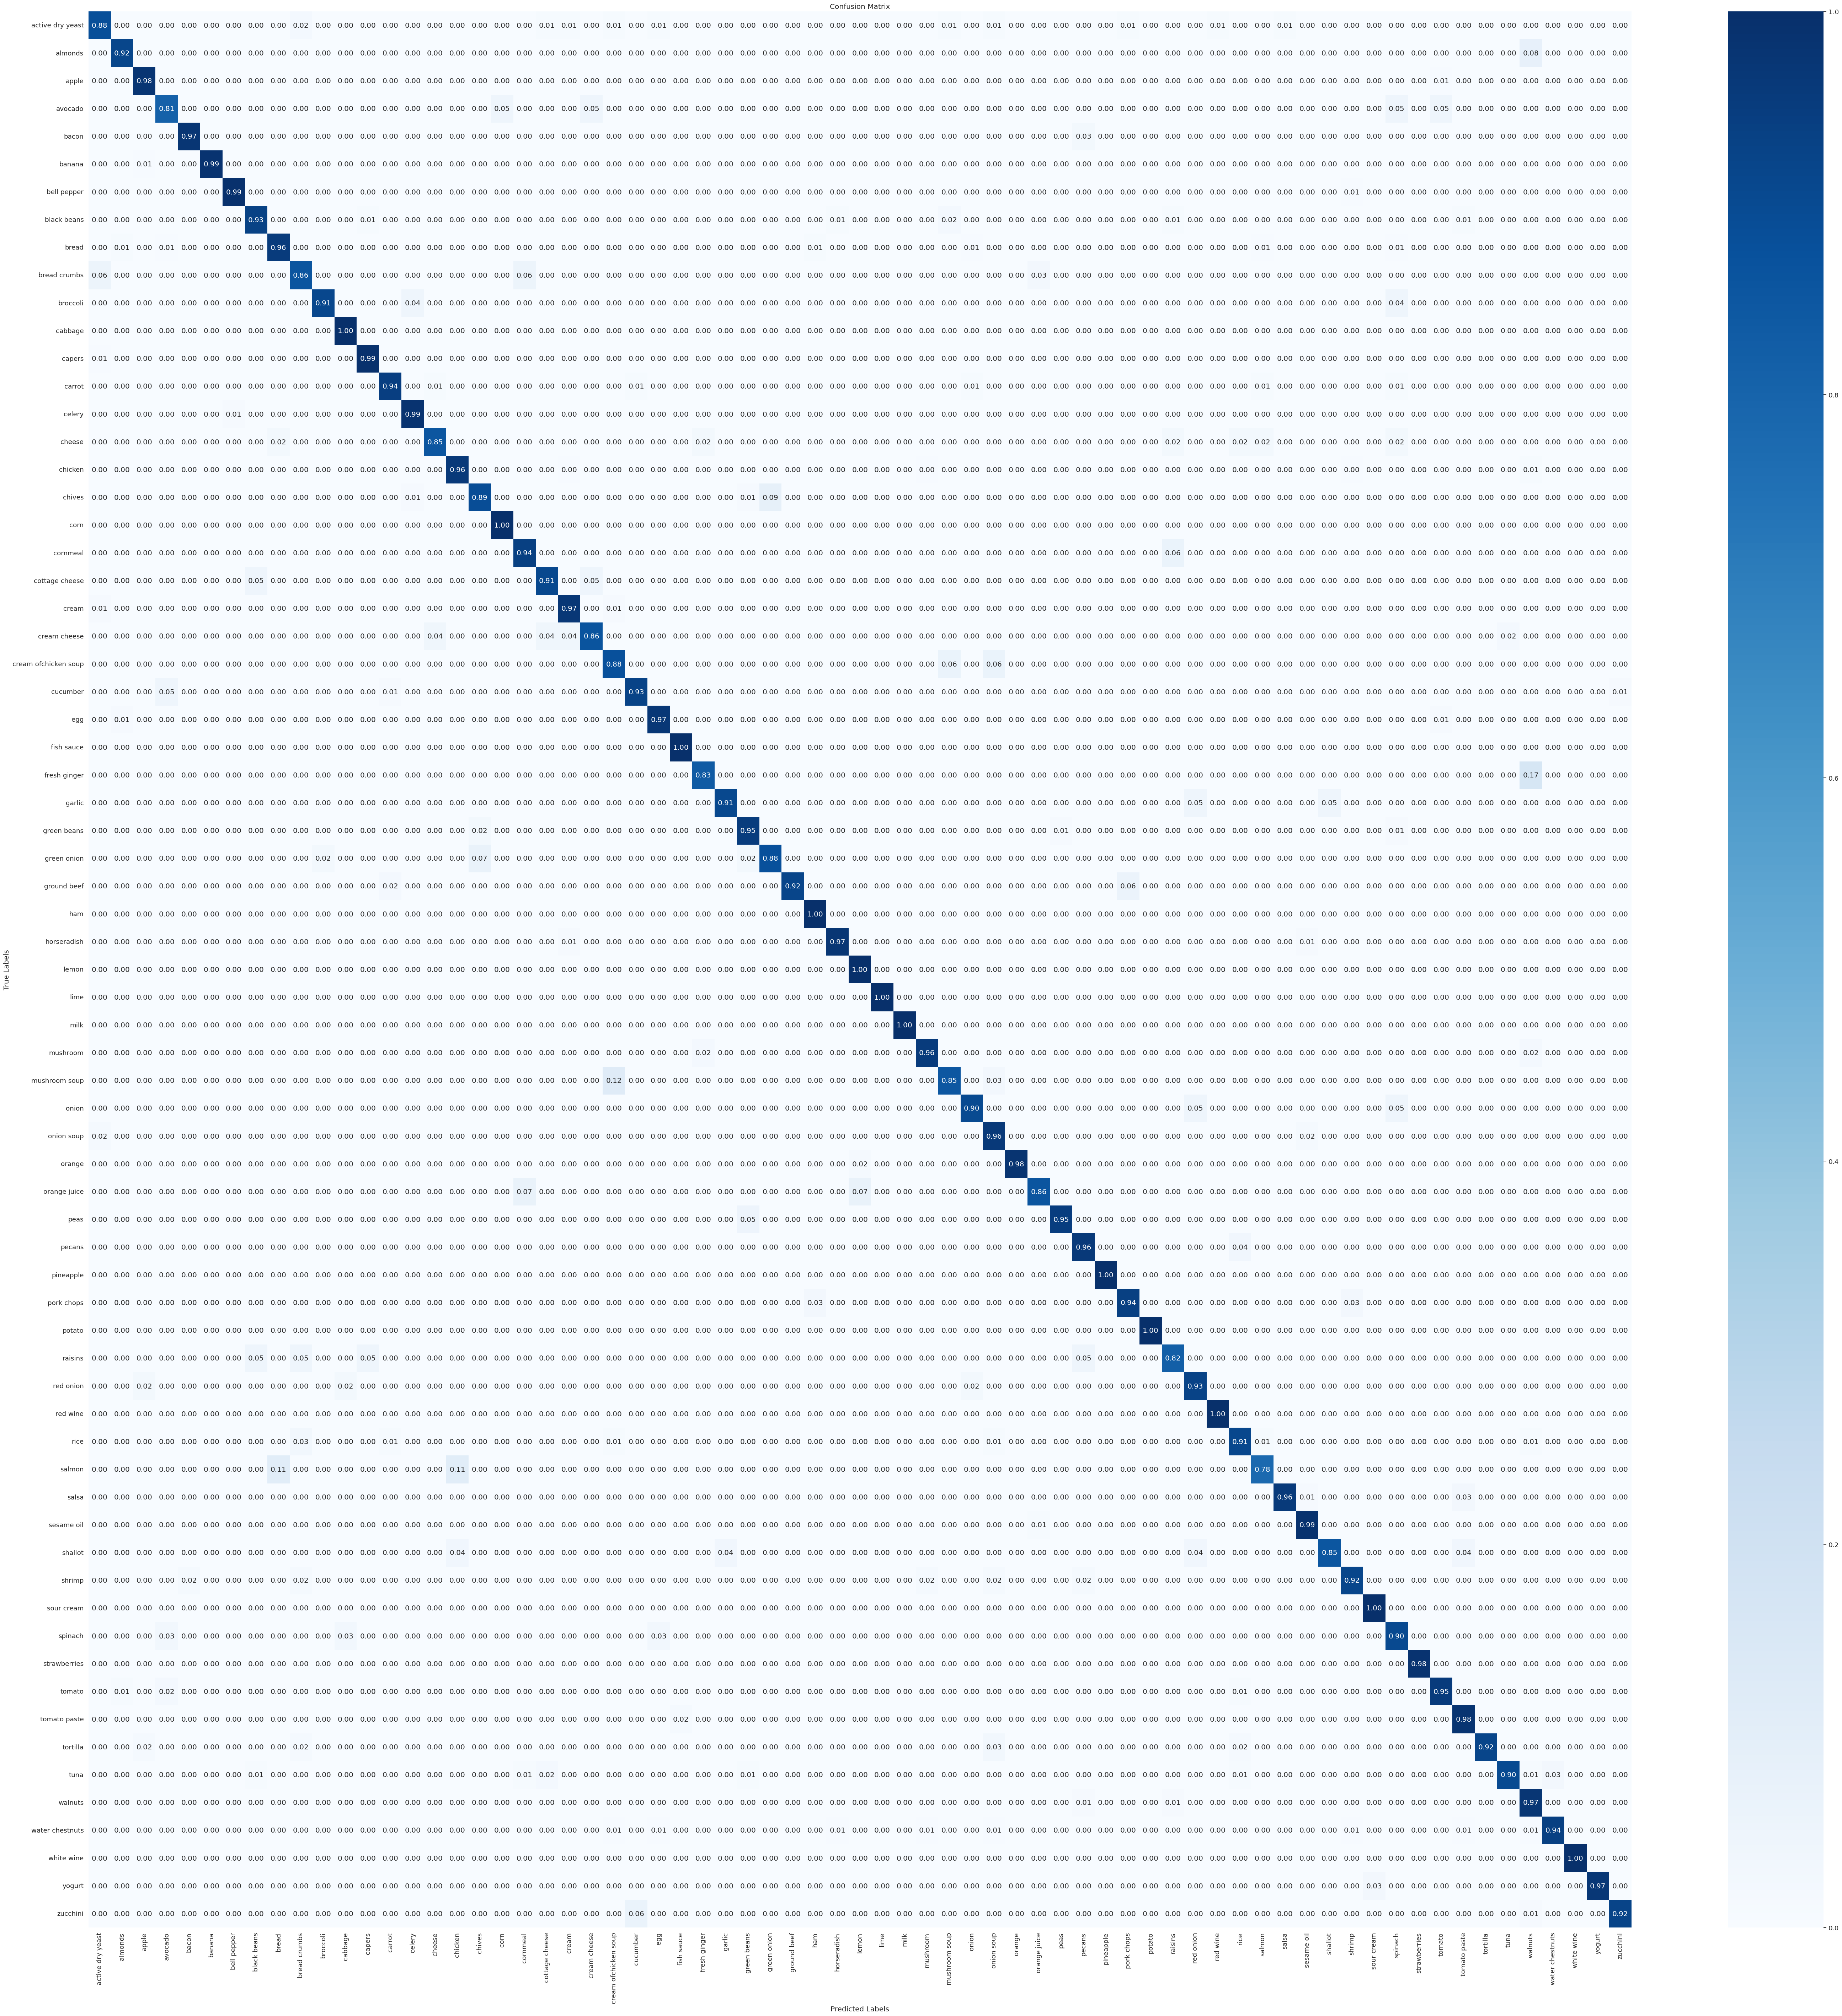

In [10]:
plt.figure(figsize=(70, 70))
sns.set_theme(font_scale=1.2)
sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=all_classes,
    yticklabels=all_classes,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()